# Imports

In [5]:
%load_ext autoreload

In [6]:
import numpy as np
from src import *

%autoreload 2

# Signal

In [13]:
# Signal width
N = 128

# Sparse signal parameters
sparse_range = (-6, 6)
density = 0.005

# Smooth signal parameters
smooth_amplitude = 2
sigmas_range = (2e-2, 2e-1)
nb_gaussian = int(0.5 * N)

# Seed
seed = None

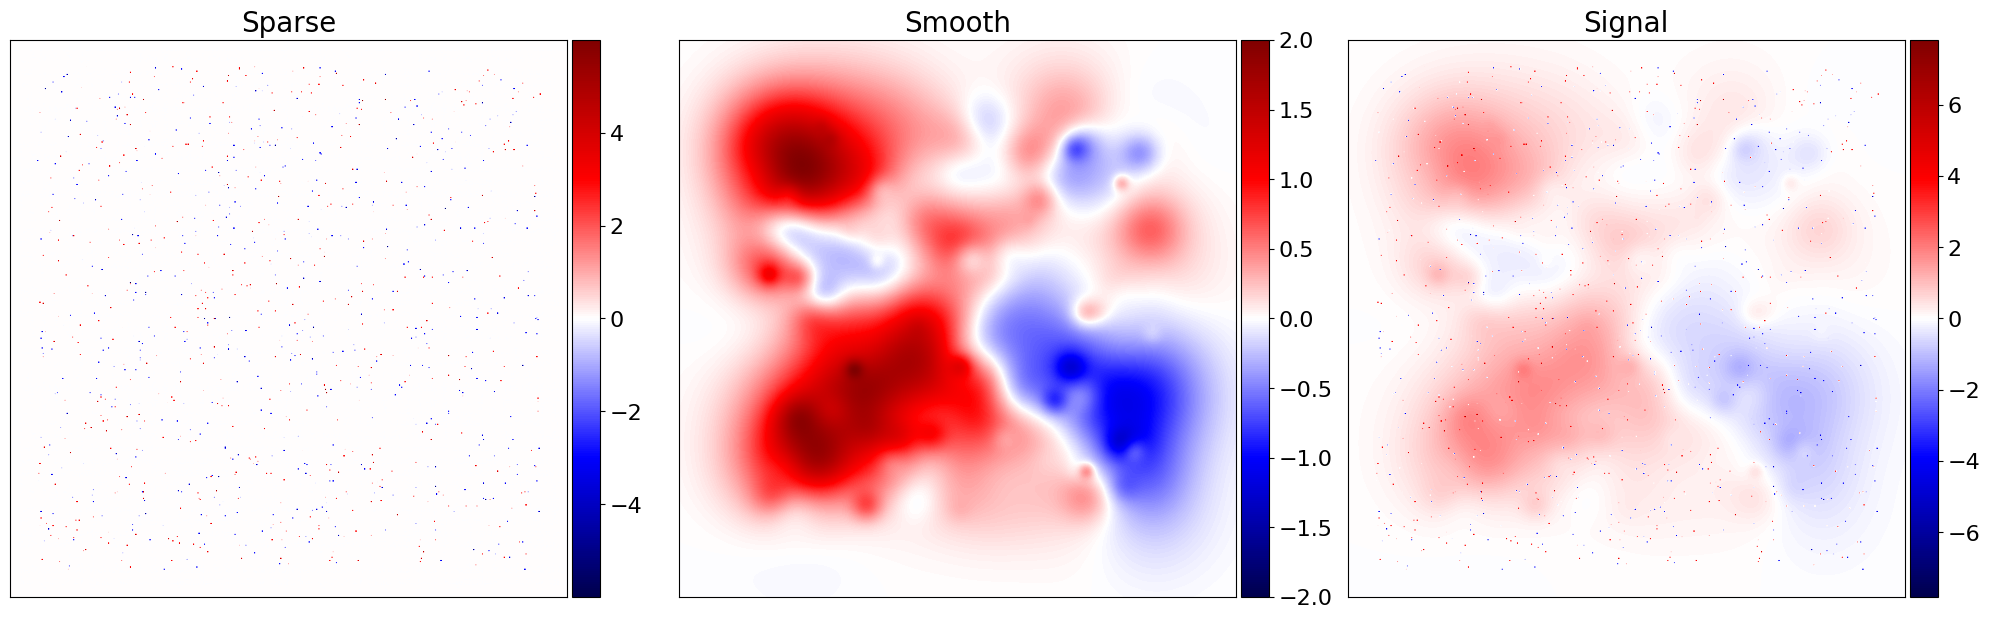

In [14]:
sparse_signal = compute_sparse(N, sparse_range, density, seed)
smooth_signal = compute_smooth(N, smooth_amplitude, sigmas_range, nb_gaussian, seed)

signal = sparse_signal + smooth_signal

plot_signal(sparse_signal, smooth_signal);

# Operator $\phi$

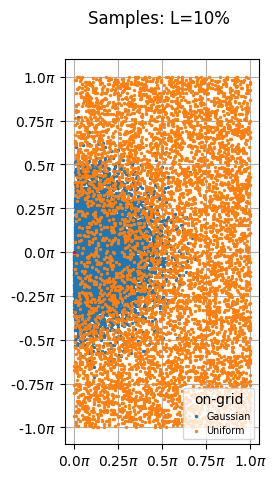

In [15]:
L = 0.1
theta = 0.5
op = NuFFT(N, L, theta, on_grid=True, seed=seed)

x0 = signal.reshape(-1)
y0 = op(x0)

psnr = 50
y = compute_y(y0, psnr)

op.plot_samples()

# Solver

In [16]:
# Loss weights
lambda1 = 1e-2
lambda2 = 5e-2

# Use Laplacian ?
laplacian = True

### Coupled

In [8]:
coupled = True

x1, x2 = solve(y, op, lambda1, lambda2, coupled, laplacian)

Coupled


Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x124608f70>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/llvmlite/binding/executionengine.py", line 171, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 


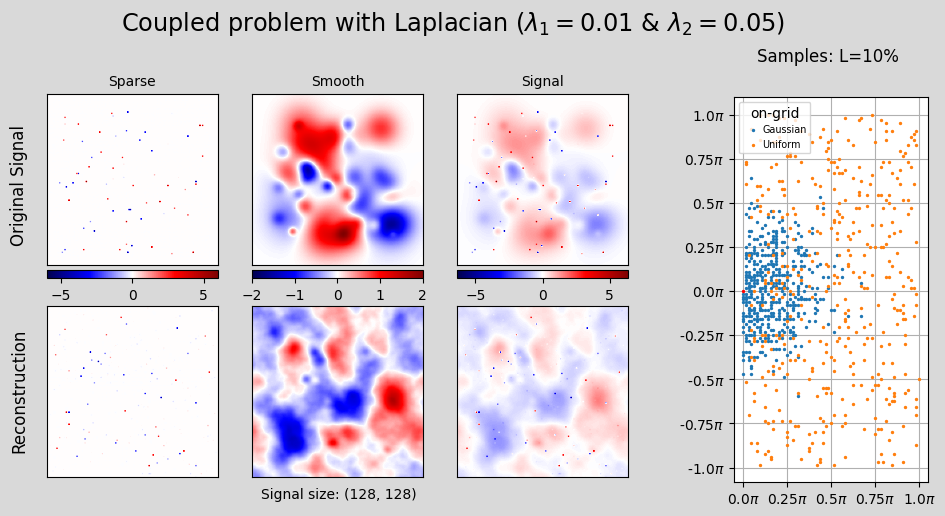

Button(description='SAVE', style=ButtonStyle())

Output()

In [42]:
sparse_rcstr_coupled, smooth_rcstr_coupled, signal_rcstr_coupled = map(
    lambda x: x.reshape((N,N)), (x1, x2, x1 + x2)
)

fig = plot_results(
    [sparse_signal, smooth_signal],
    [sparse_rcstr_coupled, smooth_rcstr_coupled],
    lambda1,
    lambda2,
    op,
    coupled,
    laplacian
)

save_widget(fig, lambda1, lambda2, op, psnr, coupled)

### Decoupled

In [17]:
coupled = False

x1_, x2_ = solve(y, op, lambda1, lambda2, coupled, laplacian)

Decoupled
Co-Gram Identity


KeyboardInterrupt: 

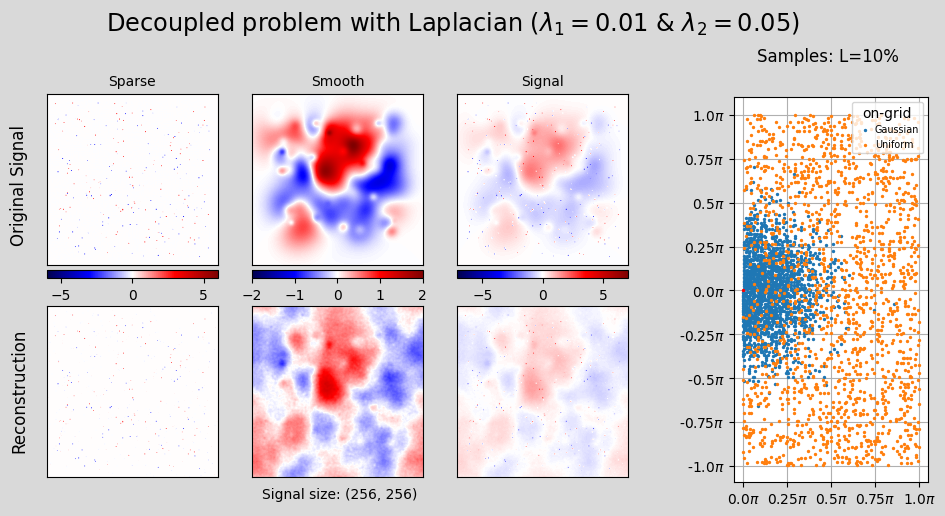

Button(description='SAVE', style=ButtonStyle())

Output()

In [12]:
sparse_rcstr_decoupled, smooth_rcstr_decoupled, signal_rcstr_decoupled = map(
    lambda x: x.reshape((N,N)), (x1_, x2_, x1_ + x2_)
)

fig = plot_results(
    [sparse_signal, smooth_signal],
    [sparse_rcstr_decoupled, smooth_rcstr_decoupled],
    lambda1,
    lambda2,
    op,
    coupled,
    laplacian
)

save_widget(fig, lambda1, lambda2, op, psnr, coupled)

les 6 reconstructions 
time
les différences smooth
                sparse - off peaks
                       - on peaks 

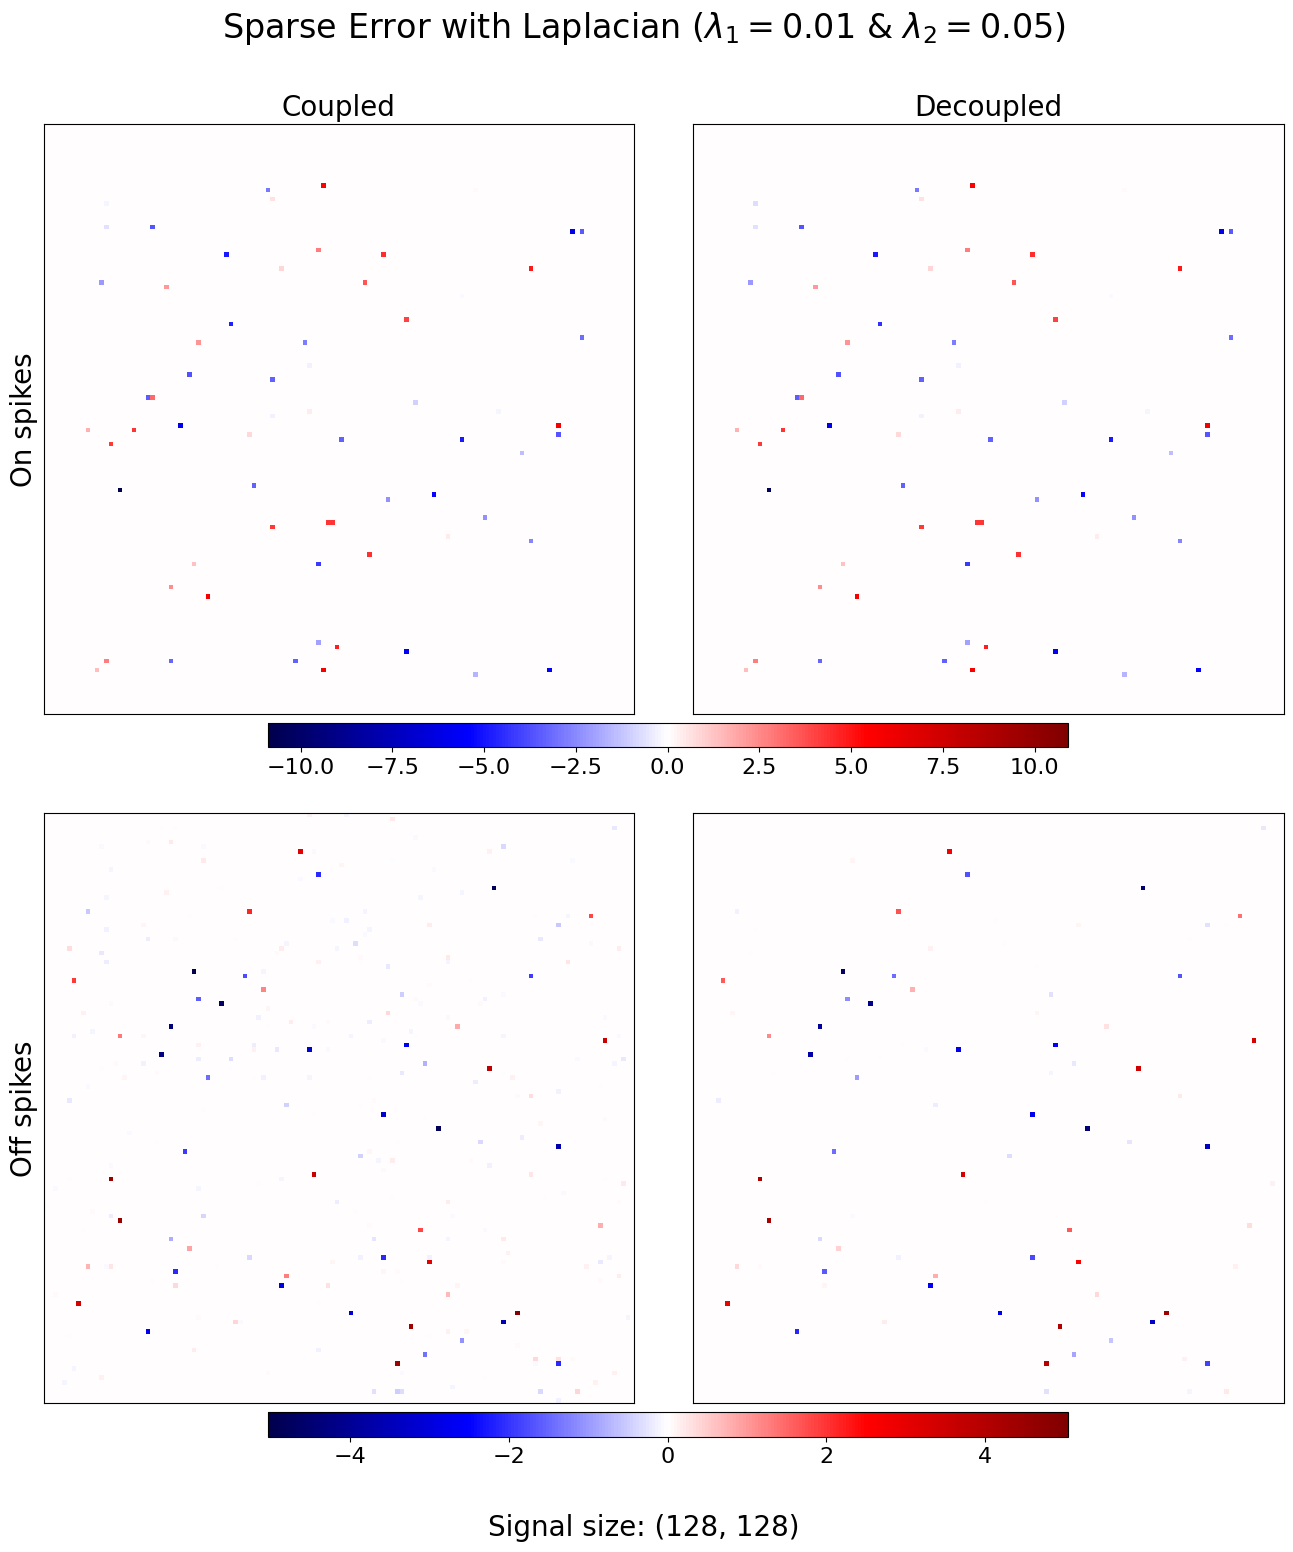

In [47]:
sparse_error(
    N,
    laplacian,
    lambda1,
    lambda2,
    sparse_signal,
    sparse_rcstr_coupled,
    sparse_rcstr_decoupled,
)
print()

evaluer cost function
temps de reconstruction (fixe taille image, lambda, 10 operations, ensuite varier taille image (512, si marche pas 256))

mettre image côte à côte (chaque taille) avec diff

In [14]:
laplacian = Laplacian((op.N, op.N), mode="wrap")
#objective_func(op,laplacian,y,sparse_rcstr )

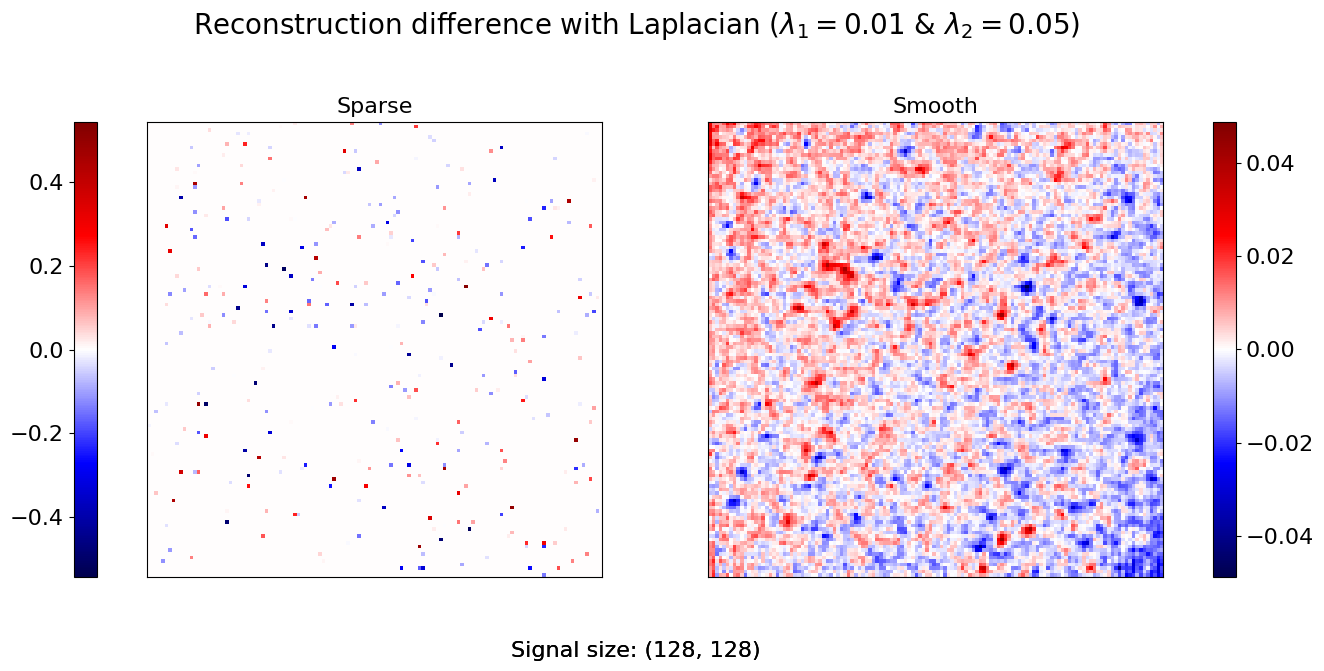

In [15]:
difference(    N,
    laplacian,
    lambda1,
    lambda2,
    sparse_rcstr_coupled,
    sparse_rcstr_decoupled,
    smooth_rcstr_coupled,
    smooth_rcstr_decoupled,);

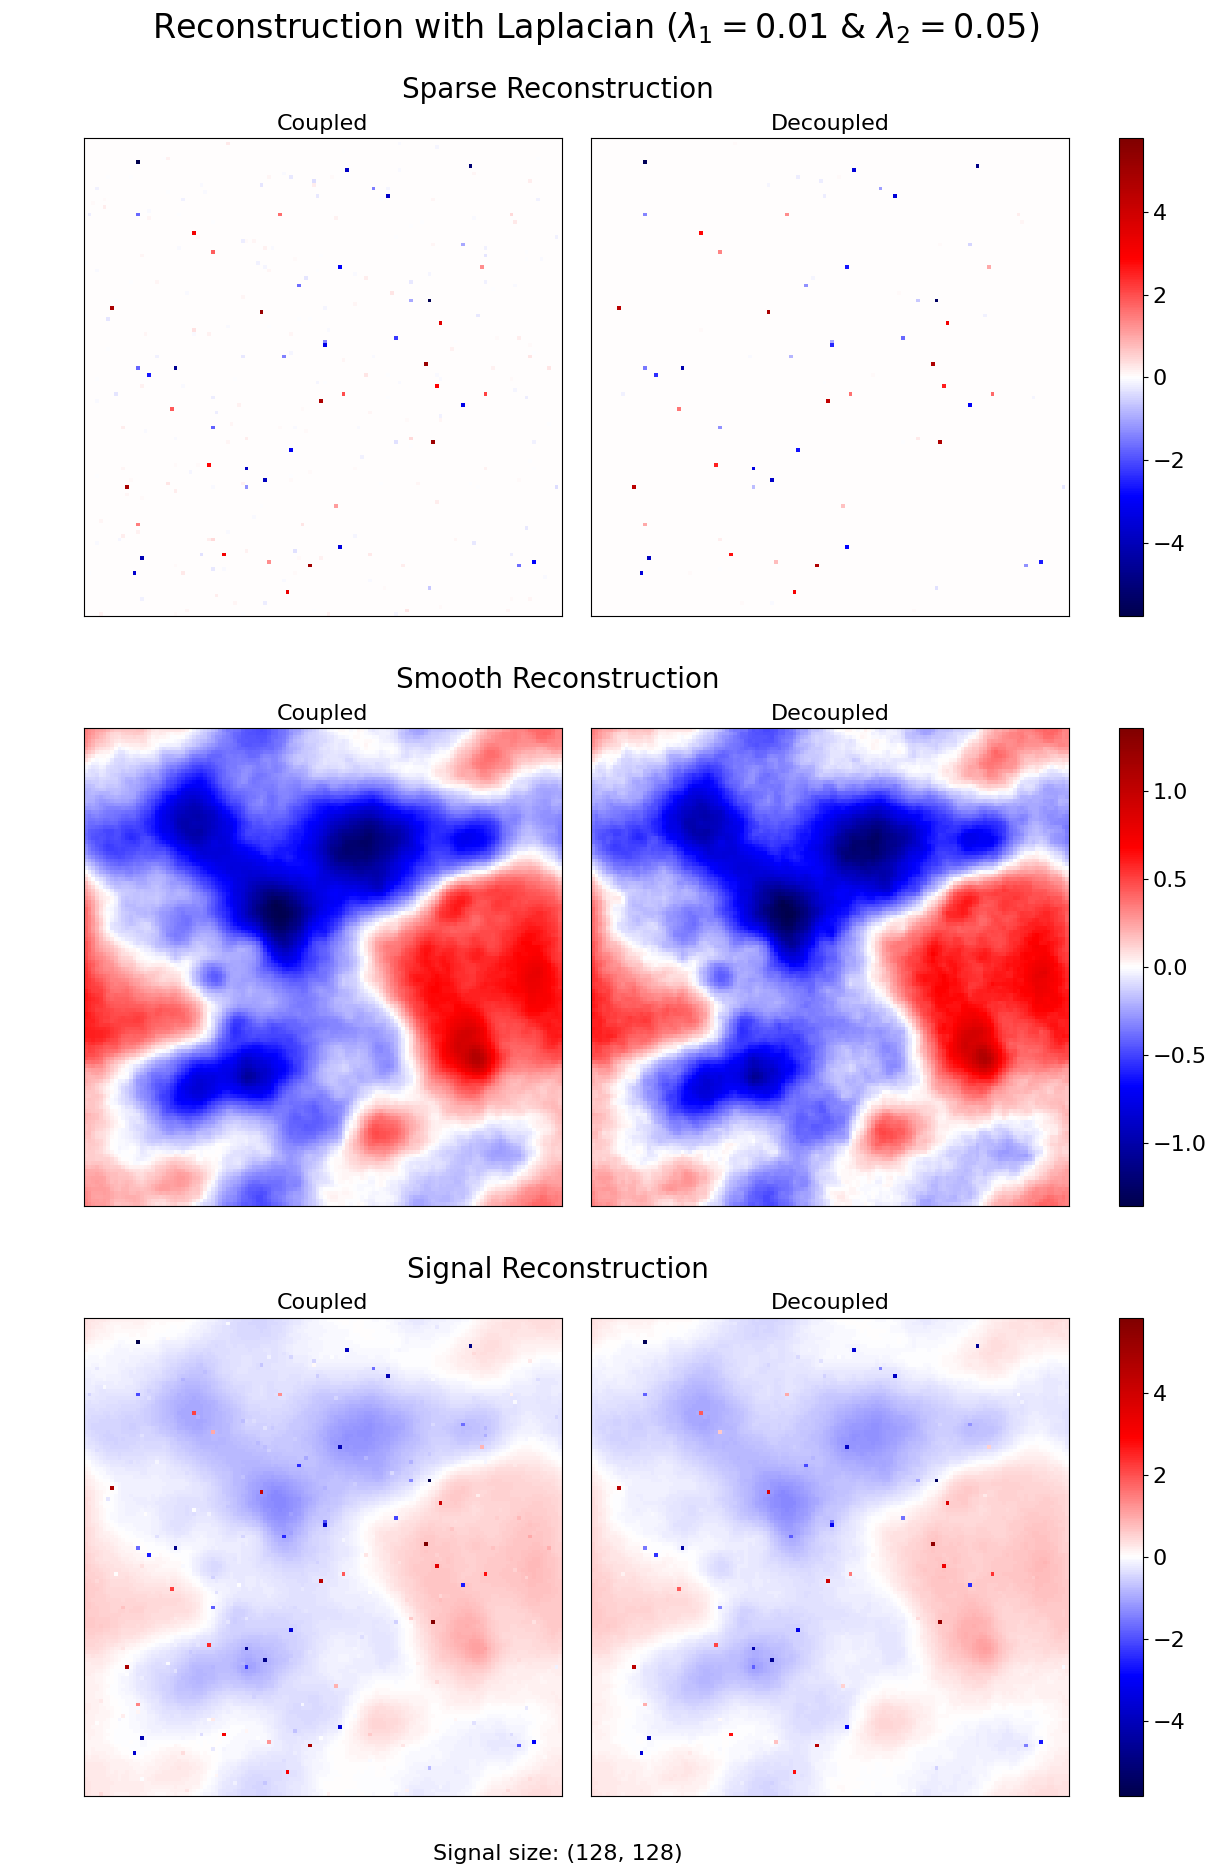

In [15]:
laplacian = True
compare(
    N,
    laplacian,
    lambda1,
    lambda2,
    sparse_rcstr_coupled,
    sparse_rcstr_decoupled,
    smooth_rcstr_coupled,
    smooth_rcstr_decoupled,
    signal_rcstr_coupled,
    signal_rcstr_decoupled,
)
print()

In [56]:
import time

In [18]:
filename = "/tests.csv"
lambda1 = 1e-2
lambda2 = 5e-2

sparse_range = (-6, 6)
density = 0.005

smooth_amplitude = 2
sigmas_range = (2e-2, 2e-1)

L = 0.1
theta = 0.5
psnr = 50

for N in [64, 96, 128, 192, 256]:
    laplacian_op = Laplacian((N, N), mode="wrap")
    nb_gaussian = int(0.5 * N)
    for seed in range(10):
        # Create signal
        sparse_signal = compute_sparse(N, sparse_range, density, seed)
        smooth_signal = compute_smooth(
            N, smooth_amplitude, sigmas_range, nb_gaussian, seed
        )
        signal = sparse_signal + smooth_signal

        fig_original_sig = plot_signal(sparse_signal, smooth_signal)
        directory_original_sig = EXP_PATH + f"/{N}/{seed}/"
        if not os.path.exists(directory_original_sig):
            os.makedirs(directory_original_sig)
        fig_original_sig.savefig(
            directory_original_sig+"original_signal", bbox_inches="tight"
        )
        # Create op
        op = NuFFT(N, L, theta, on_grid=True, seed=seed)
        x0 = signal.reshape(-1)
        y0 = op(x0)
        y = compute_y(y0, psnr)

        # Solve
        for laplacian in [True, False]:
            for coupled in [True, False]:
                start = time.time()
                x1, x2 = solve(y, op, lambda1, lambda2, coupled, laplacian)
                time_solve = time.time() - start
                (
                    sparse_rcstr,
                    smooth_rcstr,
                    signal_rcstr,
                ) = map(
                    lambda x: x.reshape((N, N)),
                    (x1, x2, x1 + x2),
                )
                cost = objective_func(
                    op,
                    laplacian_op,
                    y,
                    sparse_rcstr,
                    smooth_rcstr,
                    lambda1,
                    lambda2,
                )
                if coupled:
                    sparse_rcstr_coupled = sparse_rcstr.copy()
                    smooth_rcstr_coupled = smooth_rcstr.copy()
                    signal_rcstr_coupled = signal_rcstr.copy()
                write_to_csv(
                    filename,
                    [
                        seed,
                        N,
                        coupled,
                        laplacian,
                        lambda1,
                        lambda2,
                        time_solve,
                        *cost,
                    ],
                )

            # Compare
            fig_compare = compare(
                N,
                laplacian,
                lambda1,
                lambda2,
                sparse_rcstr_coupled,
                sparse_rcstr,
                smooth_rcstr_coupled,
                smooth_rcstr,
                signal_rcstr_coupled,
                signal_rcstr,
            )
            fig_diff = difference(
                N,
                laplacian,
                lambda1,
                lambda2,
                sparse_rcstr_coupled,
                sparse_rcstr,
                smooth_rcstr_coupled,
                smooth_rcstr,
            )
            fig_sparse = sparse_error(
                N,
                laplacian,
                lambda1,
                lambda2,
                sparse_signal,
                sparse_rcstr_coupled,
                sparse_rcstr,
            )
            PATH = EXP_PATH + f"/{N}/{seed}/{"laplacian" if laplacian else "nolaplacian"}/"
            
            if not os.path.exists(PATH):
                os.makedirs(PATH)
            for fig, file in zip(
                [fig_compare, fig_diff, fig_sparse],
                ["comparison", "difference", "sparse_error"],
            ):
                fig.savefig(PATH + file, bbox_inches="tight")
        plt.close("all")

SyntaxError: f-string: unmatched '(' (571052740.py, line 112)

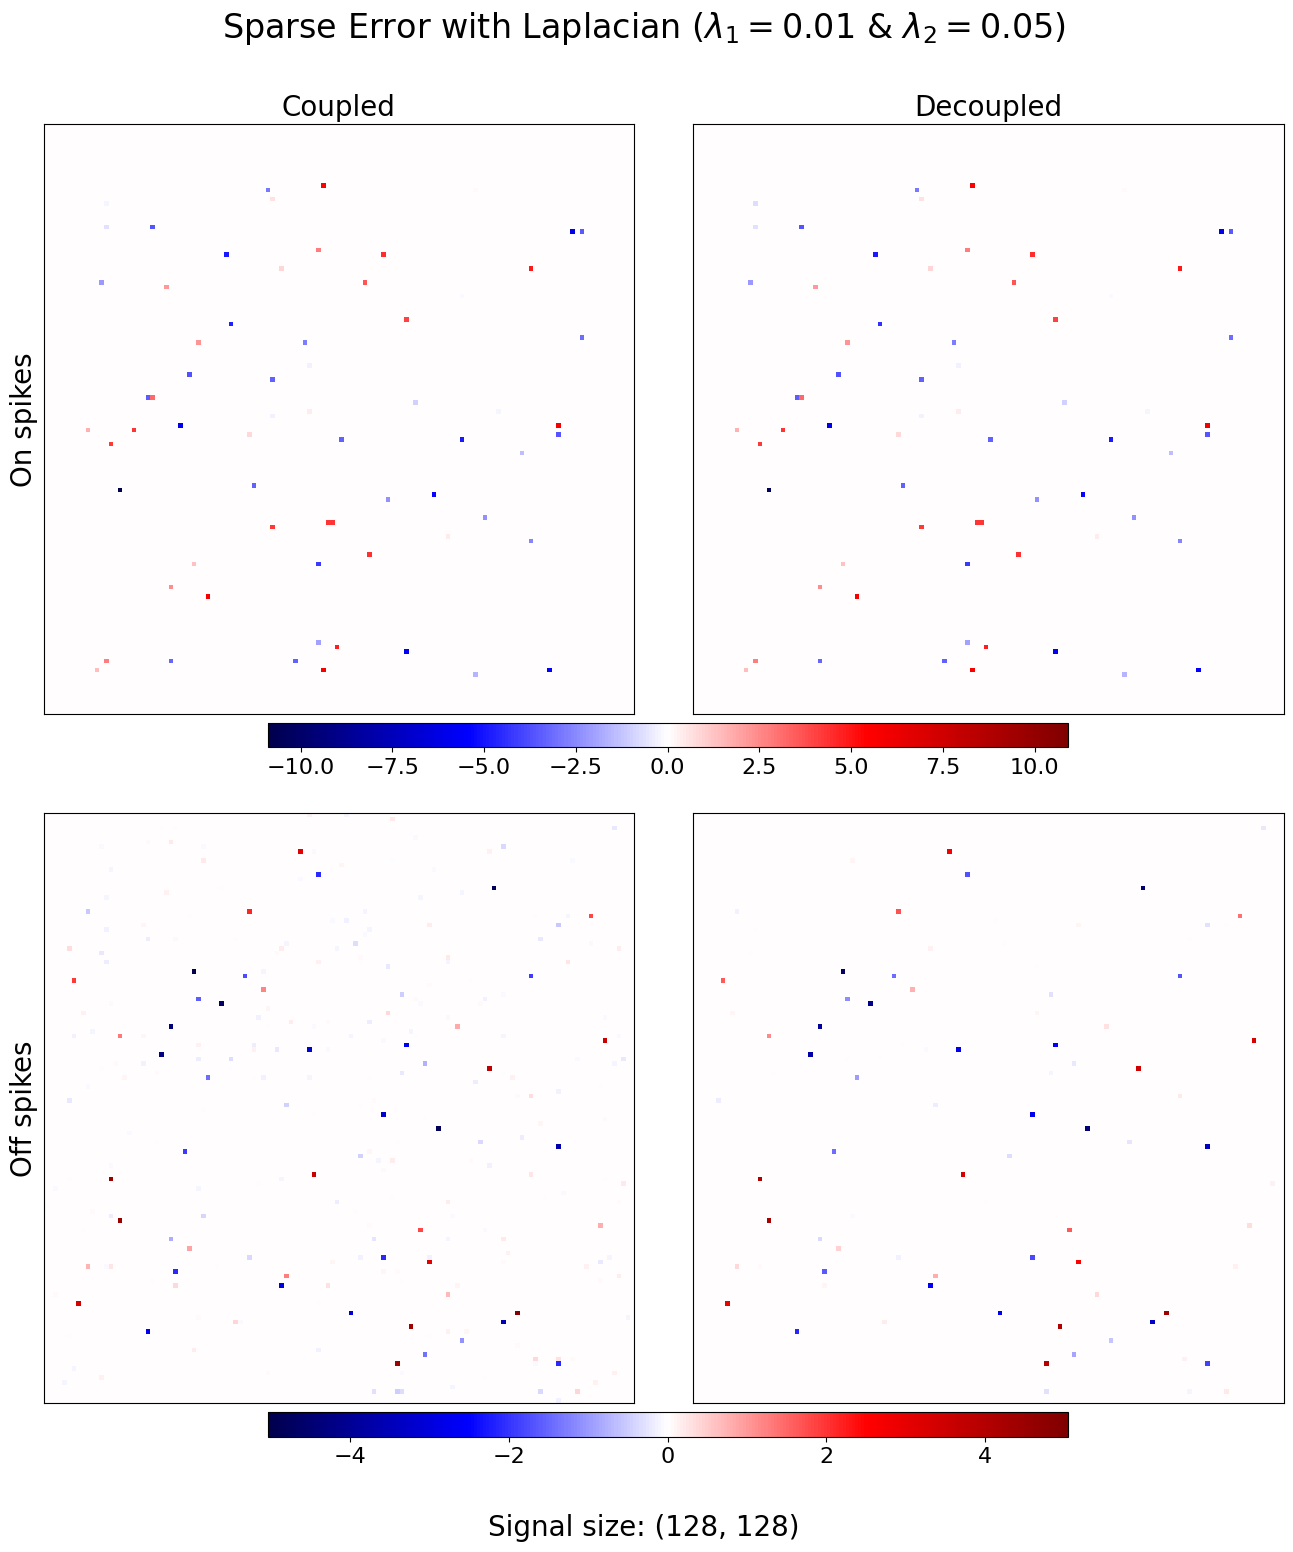

In [50]:
fig_sparse =sparse_error(
    N,
    laplacian,
    lambda1,
    lambda2,
    sparse_signal,
    sparse_rcstr_coupled,
    sparse_rcstr_decoupled,
)

fig_sparse.savefig("a", bbox_inches="tight")